In [1]:
library(tidyverse)
library(corrr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
centered_factor <- function(x) {
  f <- as.factor(x)
  n <- nlevels(f)
  
  if (n %% 2 == 1) {
    # Odd number of levels: include 0
    centered <- seq(-(n %/% 2), n %/% 2)
  } else {
    # Even number of levels: exclude 0
    centered <- seq(-n / 2, n / 2)[-((n / 2) + 1)]
  }
  
  centered[as.integer(f)]
}

corrs <- function(df){
    return(df %>% 
               #mutate(across(everything(), centered_factor)) %>% 
               mutate(across(everything(), ~ as.numeric(as.factor(.)))) %>% 
               correlate(quiet=TRUE) %>%
               as_tibble() %>%
               mutate_if(is.numeric, round, 3))
}

# Main task

In [3]:
cb <- read_csv("/Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Randomization/cb.csv", col_types = cols()) %>%
    filter(trial_type == 'test')

In [4]:
cb %>% 
    mutate(alphabet_order = ifelse(shape_pair == paste0(shape1, "-", shape2), 1, 0)) %>%
    filter(shape_pair == "croix-etoile") %>%
    select(shape_pair, agent, agent_shape, assignment_order, central_shape, outcome,
           lateral_position, movement, correct_key, alphabet_order) %>%
    # mutate(across(everything(), ~ as.numeric(as.factor(.)))) %>%
    # mutate(interaction = (agent_shape - 1) + 2 * (central_shape - 1) + 1) %>%
    # group_by(shape_pair, interaction) %>% count()
    corrs

Warning message in stats::cor(x = x, y = y, use = use, method = method):
“the standard deviation is zero”


term,shape_pair,agent,agent_shape,assignment_order,central_shape,outcome,lateral_position,movement,correct_key,alphabet_order
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
shape_pair,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
agent,NA,NA,0,0,0,0,0,0,0,0
agent_shape,NA,0,NA,0,0,0,0,0,0,0
assignment_order,NA,0,0,NA,0,0,0,0,0,0
central_shape,NA,0,0,0,NA,0,0,0,0,0
outcome,NA,0,0,0,0,NA,0,0,0,0
lateral_position,NA,0,0,0,0,0,NA,0,0,0
movement,NA,0,0,0,0,0,0,NA,0,0
correct_key,NA,0,0,0,0,0,0,0,NA,0


In [5]:
for(i in 1:30) {
    v <- cb %>% 
        filter(subject_id == i) %>%
        select(shape_pair, agent, agent_shape, assignment_order, central_shape, outcome,
            lateral_position, movement, correct_key) %>%
    #     mutate(across(everything(), ~ as.numeric(as.factor(.)))) %>%
    #     mutate(interaction = (outcome - 1) + 2 * (agent_assignment - 1) + 1) %>%
    #     group_by(shape_pair, interaction) %>% count()
        corrs %>%
        pivot_longer(-term) %>%
        filter(!is.na(value)) %>%
        pull(value) %>% max()
    if (v != 0){print(v)}}

In [6]:
prev_trial <- cb %>%
  mutate(
    same_shapes_forward = shape1 == lag(shape1) & shape2 == lag(shape2),
    same_shapes_reverse = shape1 == lag(shape2) & shape2 == lag(shape1),
    same_labels_forward = label1 == lag(label1) & label2 == lag(label2),
    same_labels_reverse = label1 == lag(label2) & label2 == lag(label1),
    diff_shapes = shape1 != lag(shape1) & shape2 != lag(shape2) &
                  shape1 != lag(shape2) & shape2 != lag(shape1),
    diff_labels = label1 != lag(label1) & label2 != lag(label2) &
                  label1 != lag(label2) & label2 != lag(label1),

    prev = case_when(
      (same_shapes_forward & same_labels_forward) |
      (same_shapes_reverse & same_labels_reverse) ~ "no_change",
      (same_shapes_reverse & same_labels_forward) |
      (same_shapes_forward & same_labels_reverse) ~ "swap",
      (same_shapes_forward | same_shapes_reverse) & diff_labels ~ "same_shapes",
      diff_shapes & (same_labels_forward | same_labels_reverse) ~ "same_referents",
      diff_shapes & diff_labels ~ "different",
      
      TRUE ~ NA
    )
  )

prev_trial %>% group_by(prev) %>% filter(!is.na(prev), prev != "no_change") %>% count()

prev,n
<chr>,<int>
different,455
same_referents,529
same_shapes,490
swap,221


In [7]:
prev_trial_mild <- cb %>%
  group_by(subject_id) %>%
  mutate(
    shape1_same = shape1 == lag(shape1) | shape1 == lag(shape2),
    shape2_same = shape2 == lag(shape1) | shape2 == lag(shape2),
    label1_same = label1 == lag(label1) | label1 == lag(label2),
    label2_same = label2 == lag(label1) | label2 == lag(label2),
    shapes_same = shape1_same & shape2_same,
    labels_same = label1_same & label2_same
    )

prev_trial_mild %>% group_by(shape1_same | shape2_same) %>% count()

shape1_same | shape2_same,n
<lgl>,<int>
FALSE,1884
TRUE,9606
NA,30


# Localizer

In [8]:
cb_loc <- read_csv("/Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Randomization/cb.csv", col_types = cols()) %>%
    filter(trial_type %in% c('word', 'image'))

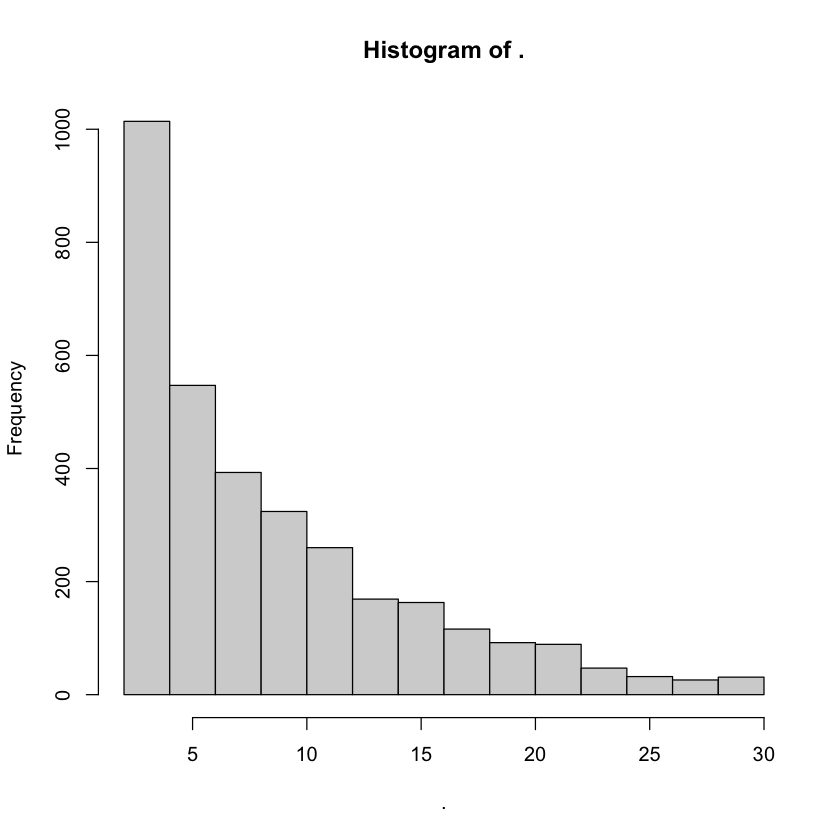

In [9]:
cb_loc %>%
    filter(correct_key == 'right') %>%
    group_by(subject_id, block_number) %>%
    mutate(diff = trial_number - lag(trial_number)) %>%
    #summarize(mean(diff, na.rm = TRUE)) %>%
    pull(diff) %>% hist()

In [10]:
cb_loc %>% 
    filter(subject_id == 1) %>%
    group_by(block_number, trial_type, shape1, label1) %>% count()

block_number,trial_type,shape1,label1,n
<dbl>,<chr>,<chr>,<chr>,<int>
0,image,carre,NA,4
0,image,cercle,NA,4
0,image,croix,NA,4
0,image,etoile,NA,4
0,image,louve,NA,4
0,image,malle,NA,4
0,image,poule,NA,4
0,image,tasse,NA,4
0,word,NA,carre,4
